In [1]:
from ngsolve import * 



In [2]:
# exact solution

uex = CF( x*(1-x)*y*(1-y) ) 
uex = CF( sin(pi*x)*sin(pi*y) )
graduex = CF( (uex.Diff(x), uex.Diff(y) ))
divgraduex = CF( graduex[0].Diff(x) + graduex[1].Diff(y) )


In [3]:
def solvePoisson(h, order):
    # input: mesh size h, and polynomial degree "order"

    # generate mesh
    mesh = Mesh(unit_square.GenerateMesh(maxh=h))

    # finite element space
    fes =H1(mesh, order = order, dirichlet = ".*")
    u,v = fes.TnT() 

    # bilinear form 
    a = BilinearForm(fes)
    a += grad(u)*grad(v)*dx 

    # linear form
    f = LinearForm(fes)
    f += - divgraduex*v*dx 

    # assemble
    a.Assemble()
    f.Assemble()

    # solve linear system
    gfu = GridFunction(fes)
    gfu.vec.data = a.mat.Inverse(freedofs = fes.FreeDofs())* f.vec
    # compute error

    errL2 = sqrt( Integrate( (gfu - uex)**2, mesh))
    errH1 = sqrt( Integrate( (grad(gfu) - graduex)**2, mesh))

    return errL2, errH1



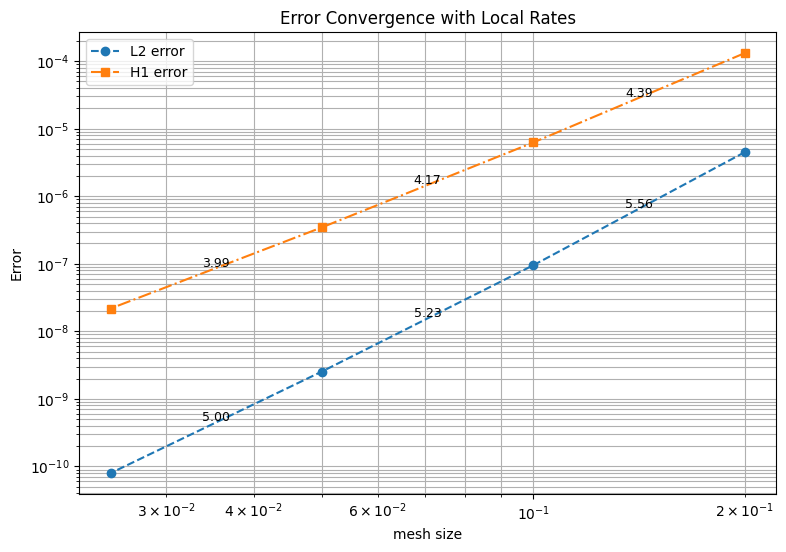

In [4]:
h = []
errL2 = []
errH1 = []

for i in range(4):
    h.append( 0.2 / ( 2**i) )
    eL2, eH1 = solvePoisson(h[-1], 4 )
    errL2.append (eL2)
    errH1.append( eH1)

import numpy as np

def compute_rates(err_vec, nel_vec):
    rates = []
    for i in range(len(nel_vec)-1):
        r = np.log(err_vec[i] / err_vec[i+1]) / np.log(h[i] / h[i+1])
        rates.append(r)
    return rates

rates_L2 = compute_rates(errL2, h)
rates_H1 = compute_rates(errH1, h)

import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))

# Plot errors
plt.loglog(h, errL2, marker="o", linestyle="--", label="L2 error")
plt.loglog(h, errH1, marker="s", linestyle="-.", label="H1 error")


# Annotate convergence rates
def annotate_rates(nel_vec, err_vec, rates, y_offset=0):
    for i in range(len(rates)):
        x_mid = np.sqrt(nel_vec[i] * nel_vec[i+1])
        y_mid = np.sqrt(err_vec[i] * err_vec[i+1])
        plt.text(x_mid, y_mid*(1+y_offset), f"{rates[i]:.2f}", fontsize=9, ha="center")

annotate_rates(h, errL2, rates_L2, y_offset=0.05)
annotate_rates(h, errH1, rates_H1, y_offset=0.05)


plt.xlabel("mesh size")
plt.ylabel("Error")
plt.title("Error Convergence with Local Rates")
plt.legend()
plt.grid(True, which="both")

plt.show()




